In [31]:
import numpy as np
from pymatching import Matching
import qecc as qc

# Translation Functions

In [5]:
#we need to make the stabilizers into a Matching object
def stabs_to_mat(stabs):
    mat = np.array([[1 if i != 'I' else 0 for i in s] for s in stabs])
    return mat
        

In [27]:
def correction_to_string(vec, correction_type):
    #correction type is 'X' or 'Z'
    op = ''.join([correction_type if i==1 else 'I' for i in vec])
    return op

# Examples

In [7]:
#example stabilizer
Hx = stabs_to_mat(['IIIXXXXXX', 'XIIXIIIII', 'IXXIXXIII'])
print(Hx)
mx = Matching(Hx)
print(mx)

Hz = stabs_to_mat(['ZZIZZIZZI', 'IZZIZZIZZ'])
print(Hz)
mz = Matching(Hz)
print(mz)

[[0 0 0 1 1 1 1 1 1]
 [1 0 0 1 0 0 0 0 0]
 [0 1 1 0 1 1 0 0 0]]
<pymatching.Matching object with 9 qubits, 3 stabilisers, 1 boundary node, and 9 edges>
[[1 1 0 1 1 0 1 1 0]
 [0 1 1 0 1 1 0 1 1]]
<pymatching.Matching object with 9 qubits, 2 stabilisers, 1 boundary node, and 9 edges>


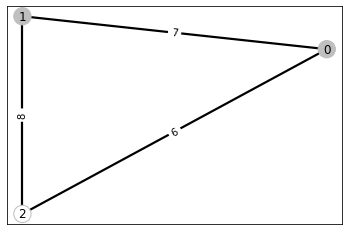

In [8]:
%matplotlib inline
mz.draw()

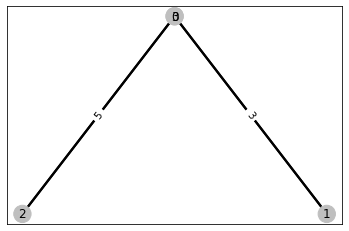

In [9]:
%matplotlib inline
mx.draw()

In [10]:
#example: deterministic noise vector
noise = np.array([0,0,0,0,0,0,0,1,0])

In [11]:
#compute the syndrome vector
z = Hx@noise % 2
print(z)

[1 0 0]


In [12]:
#apply the decoder
c = mx.decode(z)
print("c: {}, of type {}".format(c, type(c)))

c: [0 0 0 0 0 0 1 0 0], of type <class 'numpy.ndarray'>


# Noisy Syndromes

Consider a model where stabilizer measurements are noisy. The measurement is repeated some number of times, and each qubit has a probability p of an error and probability q of being measured incorrectly

In [13]:
repetitions=5
p = 0.05
q = 0.05
#construct the matching object
m2d = Matching(Hz,
               spacelike_weights=np.log((1-p)/p),
               repetitions=repetitions,
               timelike_weights=np.log((1-q)/q)
              )

In [14]:
num_stabilisers, num_qubits = Hz.shape
np.random.seed(1) # Keep RNG deterministic
noise = (np.random.rand(num_qubits, repetitions) < p).astype(np.uint8)
noise # noise generated 

array([[0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0]], dtype=uint8)

In [15]:
noise_cumulative = (np.cumsum(noise, 1) % 2).astype(np.uint8)
noise_total = noise_cumulative[:,-1] # Total cumulative noise at the last round
noise_cumulative # Cumulative errors in each time step

array([[0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0]], dtype=uint8)

In [16]:
noiseless_syndrome = Hz@noise_cumulative % 2
noiseless_syndrome # Noiseless syndrome

array([[0, 0, 1, 0, 0],
       [0, 0, 1, 0, 1]])

In [17]:
syndrome_error = (np.random.rand(num_stabilisers, repetitions) < q).astype(np.uint8)
syndrome_error[:,-1] = 0
syndrome_error # Syndrome errors

array([[0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]], dtype=uint8)

In [18]:
noisy_syndrome = (noiseless_syndrome + syndrome_error) % 2
noisy_syndrome # Noisy syndromes

array([[0, 0, 1, 0, 0],
       [1, 0, 1, 0, 1]])

In [19]:
noisy_syndrome[:,1:] = (noisy_syndrome[:,1:] - noisy_syndrome[:,0:-1]) % 2
noisy_syndrome # Convert to difference syndrome

array([[0, 0, 1, 1, 0],
       [1, 1, 1, 1, 1]])

In [20]:
#this decodes the syndrome
correction = m2d.decode(noisy_syndrome)
correction

array([0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [21]:
(noise_total + correction) % 2

array([1, 0, 0, 0, 0, 1, 0, 1, 0], dtype=uint8)

In [28]:
correction_to_string(correction, 'Z')

'IIZIIIIII'

# Decoding Function

In [62]:
def mwpm_decode(Sx, Sz, syndrome):
    Hx = stabs_to_mat(Sx)
    mx = Matching(Hx)
    
    Hz = stabs_to_mat(Sz)
    mz = Matching(Hz)
    
    cx = correction_to_string(mx.decode(syndrome[:len(Sx)]), 'X')
    cz = correction_to_string(mz.decode(syndrome[len(Sx):]), 'Z')
    
    correction = qc.Pauli(cx)*qc.Pauli(cz)
    
    return correction
    

In [53]:
(qc.Pauli(correction_to_string(correction, 'X'))*qc.Pauli(correction_to_string(correction, 'Z'))).set_phase()

i^0 IIYIIIIII

In [65]:
sx = ['IIIXXXXXX', 'XIIXIIIII', 'IXXIXXIII']
sz = ['ZZIZZIZZI', 'IZZIZZIZZ']
syndrome = [0, 1, 0, 0, 0]
correction = mwpm_decode(sx, sz, syndrome)
print(correction)

i^0 X[0]
